<a href="https://colab.research.google.com/github/jofella/Google-Colab/blob/main/Pairs_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pairs Trading
Building on the work of Delaney Mackenzie and Maxwell Margenot

Pairs trading is a classic example of a strategy based on mathematical analysis. The principle is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. If we can model this economic link with a mathematical model, we can make trades on it. We'll start by constructing a toy example.

In [12]:
# update statsmodels
!pip install statsmodels -U
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import statsmodels
statsmodels.__version__

'0.13.5'

In [14]:
#Import Packages
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)

import yfinance as yf

## Generating Two Fake Securities
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

<AxesSubplot:>

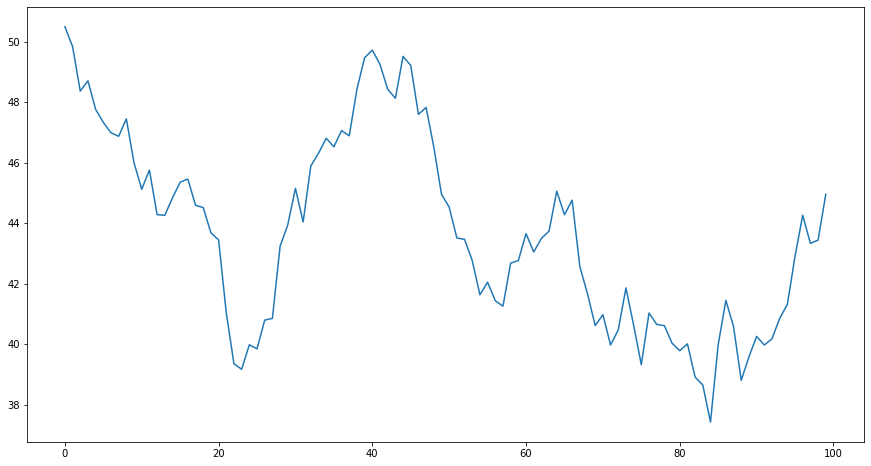

In [15]:
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot()

Now we generate Y by taking X, shifting it up and adding some random noise drawn from a normal distribution.

<AxesSubplot:>

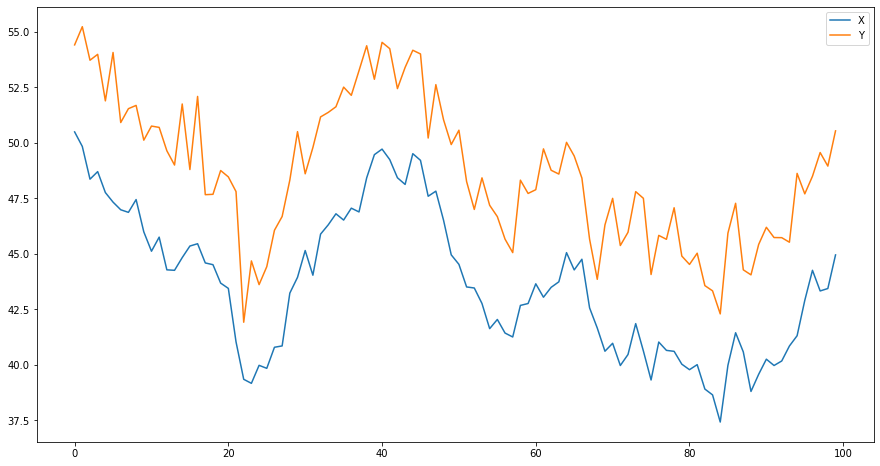

In [16]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot()

## Cointegration
We've constructed an example of two cointegrated series. Cointegration is a more subtle relationship than correlation. If two time series are cointegrated, there is some linear combination between them that will vary around a mean. At all points in time, the combination between them is related to the same probability distribution. 

We'll plot the difference between the two now so we can see how this looks.

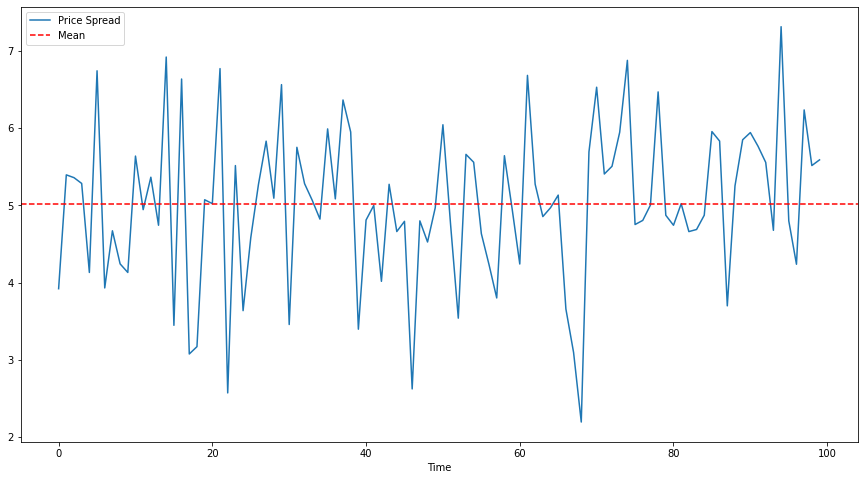

In [17]:
(Y - X).plot() # Plot the spread
plt.axhline((Y - X).mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

## Testing for Cointegration
There is a convenient cointegration test that lives in `statsmodels.tsa.stattools`. Let's say that our confidence level is $0.05$. We should see a p-value below our cutoff, as we've artifically created two series that are the textbook definition of cointegration.

In [18]:
# compute the p-value of the cointegration test
# will inform us as to whether the spread between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)
print(pvalue)

2.0503418653415035e-16


### Correlation vs. Cointegration
Correlation and cointegration, while theoretically similar, are not the same. To demonstrate this, we'll show examples of series that are correlated, but not cointegrated, and vice versa. To start let's check the correlation of the series we just generated.

In [19]:
X.corr(Y)

0.9497090646385932

That's very high, as we would expect. But how would two series that are correlated but not cointegrated look? 

### Correlation Without Cointegration
A simple example is two series that just diverge.

<AxesSubplot:>

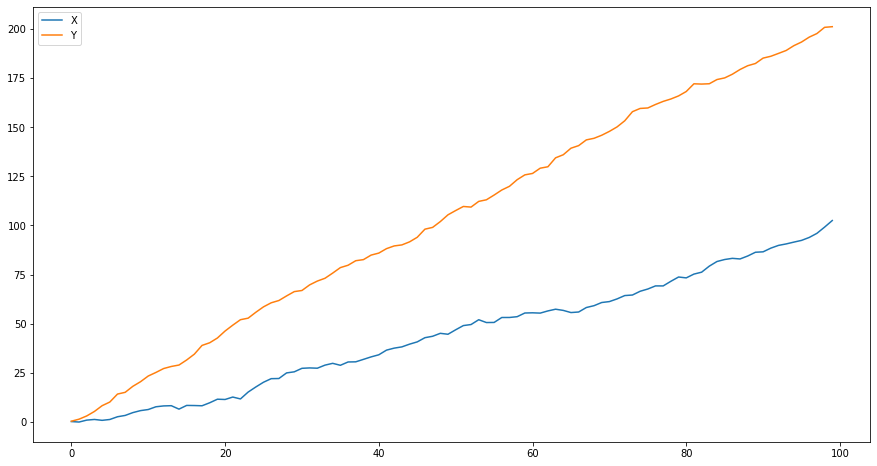

In [20]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)

X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')

pd.concat([X_diverging, Y_diverging], axis=1).plot()

In [21]:
print('Correlation: ' + str(X_diverging.corr(Y_diverging)))
score, pvalue, _ = coint(X_diverging,Y_diverging)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: 0.9931343801275687
Cointegration test p-value: 0.8815557674695222


### Cointegration Without Correlation
A simple example of this case is a normally distributed series and a square wave.

In [22]:
Y2 = pd.Series(np.random.normal(0, 1, 1000), name='Y2') + 20
Y3 = Y2.copy()

In [23]:
# Y2 = Y2 + 10
Y3[0:100] = 30
Y3[100:200] = 10
Y3[200:300] = 30
Y3[300:400] = 10
Y3[400:500] = 30
Y3[500:600] = 10
Y3[600:700] = 30
Y3[700:800] = 10
Y3[800:900] = 30
Y3[900:1000] = 10

(0.0, 40.0)

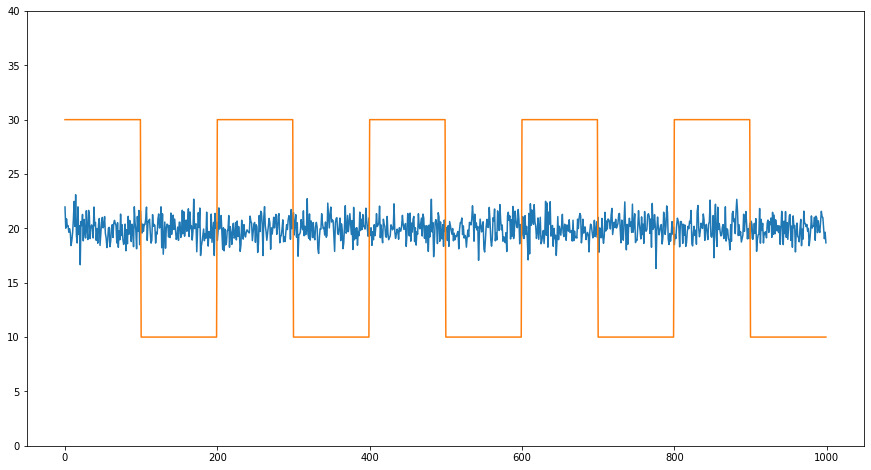

In [24]:
Y2.plot()
Y3.plot()
plt.ylim([0, 40])

In [25]:
# correlation is nearly zero
print('Correlation: ' + str(Y2.corr(Y3)))
score, pvalue, _ = coint(Y2,Y3)
print('Cointegration test p-value: ' + str(pvalue))

Correlation: -0.04130406958091664
Cointegration test p-value: 0.0


Sure enough, the correlation is incredibly low, but the p-value shows that these are cointegrated.

## Hedging
Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across X and Y. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the spread of the two reverting to the mean. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

### Going Long the Spread
This is when the spread is small and we expect it to become larger. We place a bet on this by longing Y and shorting X.

### Going Short the Spread
This is when the spread is large and we expect it to become smaller. We place a bet on this by shorting Y and longing X.


Here's a method to look through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than $0.05$.

In [26]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Alternative Energy Securities
We are looking through a set of solar company stocks to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security for the year of 2014.

Our approach here is somewhere in the middle of the spectrum that we mentioned before. We have formulated an economic hypothesis that there is some sort of link between a subset of securities within the energy sector and we want to test whether there are any cointegrated pairs. This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

NOTE: We include the market in our data. This is because the market drives the movement of so many securities that you often times might find two seemingingly cointegrated securities, but in reality they are not cointegrated and just both conintegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.

In [27]:
symbol_str = "SU ASTI TS DQ FSLR SPY VLO OXY EC MPLX"
symbol_list = ['SU', 'ASTI', 'TS', 'DQ', 'FSLR', 'SPY', 
'VLO', 'OXY', 'EC', 'MPLX']

prices_df = yf.download(symbol_str, start="2020-01-01", end="2021-01-01")['Adj Close']

[*********************100%***********************]  10 of 10 completed

1 Failed download:
- ASTI: Data doesn't exist for startDate = 1577854800, endDate = 1609477200


Example of how to get all the prices of all the stocks loaded using get_pricing() above in one pandas dataframe object

In [28]:
prices_df.head()

,ASTI,DQ,EC,FSLR,MPLX,OXY,SPY,SU,TS,VLO
Date,,,,,,,,,,
2020-01-02,NaN,10.996,15.780486,57.240002,17.842707,40.842556,309.694916,28.684847,21.269939,81.070686
2020-01-03,NaN,10.890,15.912573,57.020000,17.780706,41.830524,307.349823,28.719852,21.636662,77.994194
2020-01-06,NaN,10.770,15.850415,55.830002,18.331831,43.211769,308.522339,29.673672,21.787113,78.002747
2020-01-07,NaN,10.672,15.928113,56.669998,18.504059,43.422791,307.654938,29.839941,21.993980,79.025406
2020-01-08,NaN,10.876,15.803795,56.700001,18.504059,43.144623,309.294495,29.673672,21.815323,79.332176


Example of how to get just the prices of a single stock that was loaded using get_pricing() above

In [29]:
prices_df['SPY'].head()

Date
2020-01-02    309.694916
2020-01-03    307.349823
2020-01-06    308.522339
2020-01-07    307.654938
2020-01-08    309.294495
Name: SPY, dtype: float64

Now we'll run our method on the list and see if any pairs are cointegrated.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1721: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  

[('ASTI', 'DQ'), ('ASTI', 'EC'), ('ASTI', 'FSLR'), ('ASTI', 'MPLX'), ('ASTI', 'OXY'), ('ASTI', 'SPY'), ('ASTI', 'SU'), ('ASTI', 'TS'), ('ASTI', 'VLO'), ('OXY', 'SU')]


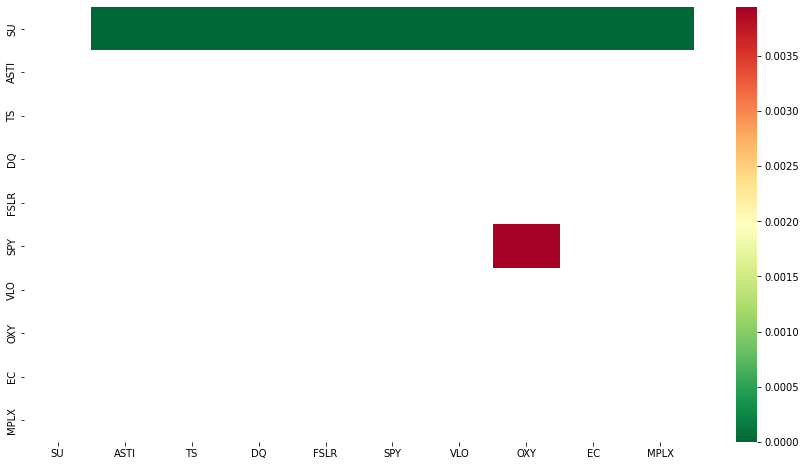

In [30]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(prices_df)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
print(pairs)

Looks like 'ABGB' and 'FSLR' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

In [31]:
S1 = prices_df['OXY']
S2 = prices_df['SU']

In [32]:
score, pvalue, _ = coint(S1, S2)
pvalue

0.003944901136428206

## Calculating the Spread
Now we will plot the spread of the two series. In order to actually calculate the spread, we use a linear regression to get the coefficient for the linear combination to construct between our two securities (see stationarity). Using a linear regression to estimate the coefficient is known as the Engle-Granger method.

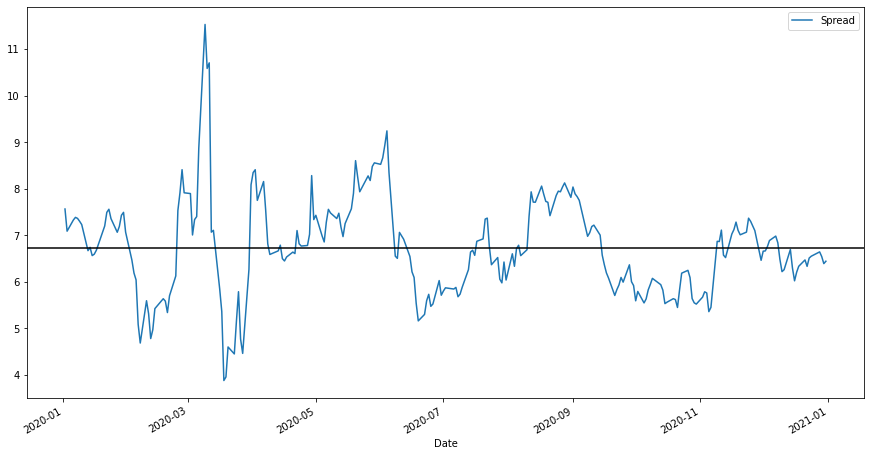

In [33]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['OXY']
b = results.params['OXY']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

Alternatively, we could examine the ratio betwen the two series.

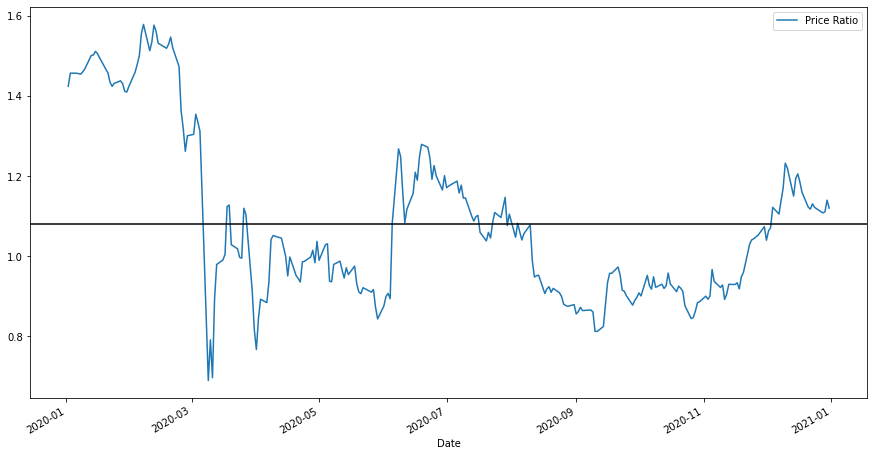

In [34]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio'])

Examining the price ratio of a trading pair is a traditional way to handle pairs trading. Part of why this works as a signal is based in our assumptions of how stock prices move, specifically because stock prices are typically assumed to be log-normally distributed. What this implies is that by taking a ratio of the prices, we are taking a linear combination of the returns associated with them (since prices are just the exponentiated returns).

This can be a little irritating to deal with for our purposes as purchasing the precisely correct ratio of a trading pair may not be practical. We choose instead to move forward with simply calculating the spread between the cointegrated stocks using linear regression. This is a very simple way to handle the relationship, however, and is likely not feasible for non-toy examples. There are other potential methods for estimating the spread listed at the bottom of this notebook. 

So, back to our example. The absolute spread isn't very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. 

### WARNING
In practice this is usually done to try to give some scale to the data, but this assumes some underlying distribution, usually a normal distribution. Under a normal distribution, we would know that approximately 84% of all spread values will be smaller. However, much financial data is not normally distributed, and one must be very careful not to assume normality, nor any specific distribution when generating statistics. It could be the case that the true distribution of spreads was very fat-tailed and prone to extreme values. This could mess up our model and result in large losses.

In [35]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

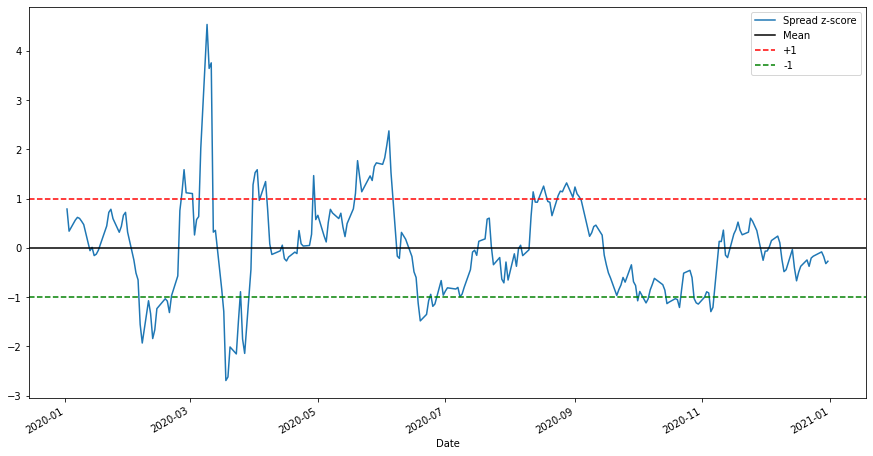

In [36]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])

### Simple Strategy:
* Go "Long" the spread whenever the z-score is below -1.0
* Go "Short" the spread when the z-score is above 1.0
* Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.  In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2.  Some additional resources on pair trading are listed at the end of this notebook

## Trading using constantly updating statistics
In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

## Moving Averages
A moving average is just an average over the last $n$ datapoints for each given time. It will be undefined for the first $n$ datapoints in our series. Shorter moving averages will be more jumpy and less reliable, but respond to new information quickly. Longer moving averages will be smoother, but take more time to incorporate new information.

We also need to use a rolling beta, a rolling estimate of how our spread should be calculated, in order to keep all of our parameters up to date.

Text(0, 0.5, 'Spread')

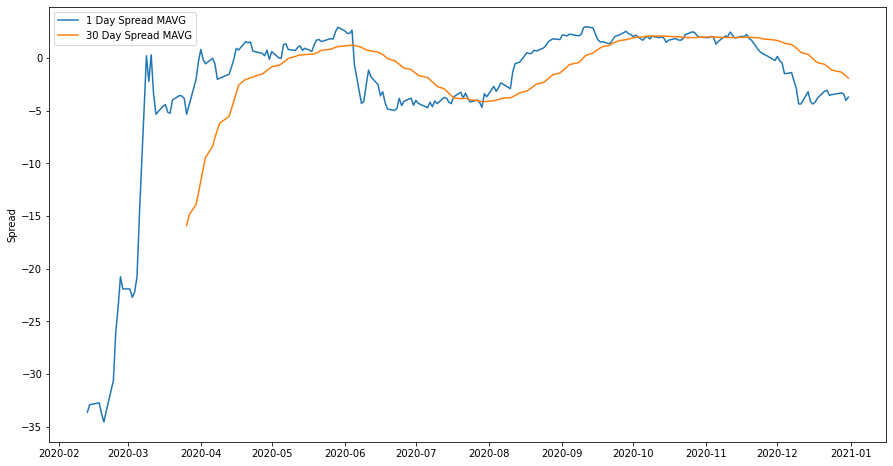

In [37]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
rolling_beta = RollingOLS(S1, S2, window=30)
rres = rolling_beta.fit()
spread = S2 - rres.params.values.ravel() * S1.values
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = spread.rolling(window=1).mean()
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = spread.rolling(window=30).mean()
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread')

We can use the moving averages to compute the z-score of the spread at each given time. This will tell us how extreme the spread is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

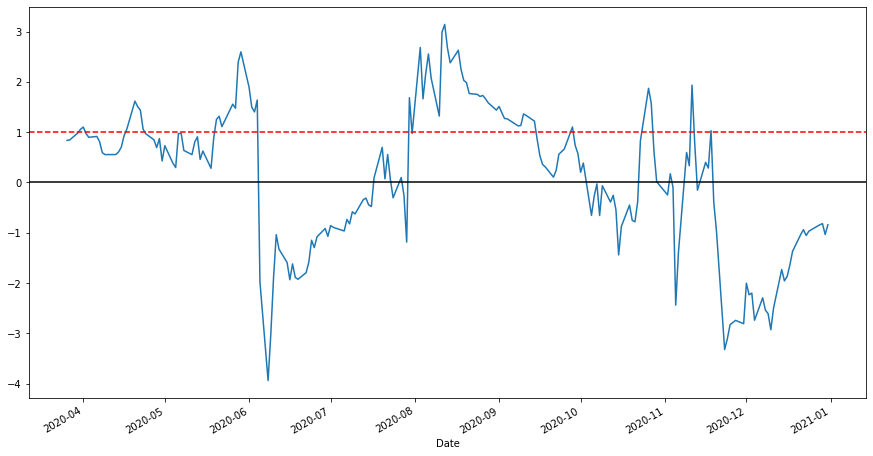

In [38]:
# Take a rolling 30 day standard deviation
std_30 = spread.rolling(window=30).std()
std_30.name = 'std 30d'

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30
zscore_30_1.name = 'z-score'
zscore_30_1.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the spreads were all negative and that is a little counterintuitive to trade on.

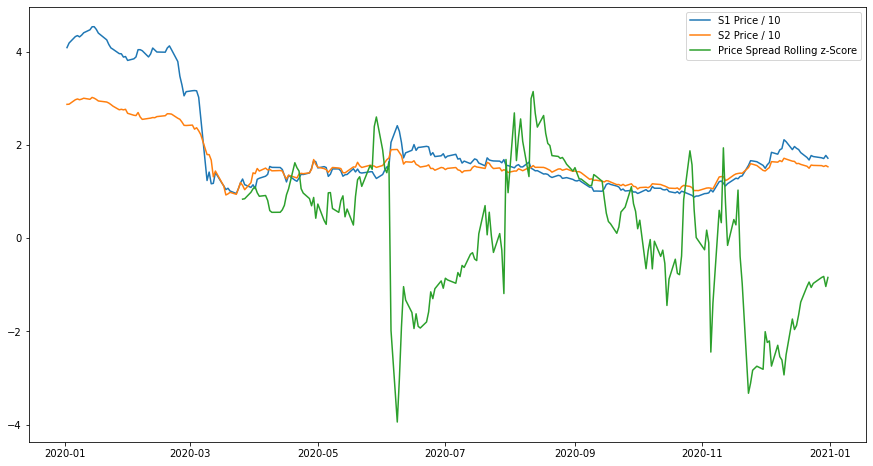

In [39]:
# Plot the prices scaled down along with the negative z-score
# just divide the stock prices by 10 to make viewing it on the plot easier
plt.plot(S1.index, S1.values/10)
plt.plot(S2.index, S2.values/10)
plt.plot(zscore_30_1.index, zscore_30_1.values)
plt.legend(['S1 Price / 10', 'S2 Price / 10', 'Price Spread Rolling z-Score'])

## Out of Sample Test
Now that we have constructed our spread appropriately and have an idea of how we will go about making trades, it is time to conduct some out of sample testing. Our whole model is based on the premise that these securities are cointegrated, but we built it on information from a certain time period. If we actually want to implement this model, we need to conduct an out of sample test to confirm that the principles of our model are still valid going forward.

Since we initially built the model on the 2014 - 2015 year, let's see if this cointegrated relationship holds for 2015 - 2016. Historical results do not guarantee future results so this is a sanity check to see if the work we have done holds strong.

In [40]:
symbol_str = "SU OXY"
symbol_list = ['SU', 'OXY']

prices_df = yf.download(symbol_str, start="2021-01-02", end="2021-10-01")['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [41]:
S1 = prices_df['OXY']
S2 = prices_df['SU']

In [42]:
score, pvalue, _ = coint(S1, S2)
print('p-value: ', pvalue)

p-value:  0.12515743698729892


Unfortunately, since our p-value is above the cutoff of $0.05$, we conclude that our model will no longer be valid due to the lack of cointegration between our chosen securities. If we tried to deploy this model without the underlying assumptions holding, we would have no reason to believe that it would actually work. Out of sample testing is a vital step to make sure that our work will actually be viable in the market.

## Implementation
When actually implementing a pairs trading strategy you would normally want to be trading many different pairs at once. If you find a good pair relationship by analyzing data, there is no guarantee that that relationship will continue into the future. Trading many different pairs creates a diversified portfolio to mitigate the risk of individual pairs "falling out of" cointegration.


## Further Research
This notebook contained some simple introductory approaches. In practice one should use more sophisticated statistics, some of which are listed here.

* Augmented-Dickey Fuller test 
* Hurst exponent
* Half-life of mean reversion inferred from an Ornstein–Uhlenbeck process
* Kalman filters

Ref: Dr. Ernie Chan, "Algorithmic Trading: Winning Strategies and Their Rationale"